In [24]:
import os, random, json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageEnhance

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Dense, Dropout,
                                     GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize


In [25]:
os.environ['PYTHONHASHSEED'] = '0'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
train_dir = r"C:\M.Tech CSE\CV Project\Brain Tumor Detection and Classification\archive\Training"
test_dir  = r"C:\M.Tech CSE\CV Project\Brain Tumor Detection and Classification\archive\Testing"
IMAGE_SIZE = 128
BATCH_SIZE = 12
VAL_SPLIT = 0.2   # 20% validation

In [5]:
# Define consistent class names (sorted order)
CLASS_NAMES = sorted([d for d in os.listdir(train_dir)
                      if os.path.isdir(os.path.join(train_dir, d))])
CLASS_TO_INDEX = {c: i for i, c in enumerate(CLASS_NAMES)}
INDEX_TO_CLASS = {i: c for c, i in CLASS_TO_INDEX.items()}

with open("class_names.json", "w") as f:
    json.dump(CLASS_NAMES, f)

In [6]:
def preprocess_image(path):
    img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    arr = img_to_array(img) / 255.0
    return arr

def augment_array(arr):
    im = Image.fromarray((arr * 255).astype("uint8"))
    im = ImageEnhance.Brightness(im).enhance(random.uniform(0.8, 1.2))
    im = ImageEnhance.Contrast(im).enhance(random.uniform(0.8, 1.2))
    arr2 = np.array(im).astype("float32") / 255.0
    return np.clip(arr2, 0.0, 1.0)

def open_images_train(paths):
    return np.array([augment_array(preprocess_image(p)) for p in paths])

def open_images_test(paths):
    return np.array([preprocess_image(p) for p in paths])

def encode_labels(labels):
    return np.array([CLASS_TO_INDEX[l] for l in labels])

In [7]:
def load_dataset(directory):
    paths, labels = [], []
    for cls in CLASS_NAMES:
        folder = os.path.join(directory, cls)
        for fname in os.listdir(folder):
            paths.append(os.path.join(folder, fname))
            labels.append(cls)
    return paths, labels

train_paths, train_labels = load_dataset(train_dir)
test_paths, test_labels = load_dataset(test_dir)

In [8]:
# Shuffle training data
combined = list(zip(train_paths, train_labels))
random.shuffle(combined)
train_paths, train_labels = zip(*combined)

In [9]:
# Split into training + validation
split_idx = int(len(train_paths) * (1 - VAL_SPLIT))
train_paths, val_paths = train_paths[:split_idx], train_paths[split_idx:]
train_labels, val_labels = train_labels[:split_idx], train_labels[split_idx:]

In [10]:
# Encode validation & test labels
val_images = open_images_test(val_paths)
val_labels_encoded = encode_labels(val_labels)

test_images = open_images_test(test_paths)
test_labels_encoded = encode_labels(test_labels)

In [11]:
def datagen(paths, labels, batch_size=BATCH_SIZE, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            batch_images = open_images_train(batch_paths)
            batch_encoded = encode_labels(batch_labels)
            yield batch_images, batch_encoded

In [12]:
base_model = VGG16(weights="imagenet", include_top=False,
                   input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(len(CLASS_NAMES), activation="softmax")
])

model.compile(optimizer=Adam(1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,780,868 (56.38 MB)

 Trainable params: 66,180 (258.52 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
EPOCHS = 20
steps = len(train_paths) // BATCH_SIZE

early_stop = EarlyStopping(monitor="val_accuracy",
                           patience=3,
                           restore_best_weights=True)

history = model.fit(
    datagen(train_paths, train_labels, BATCH_SIZE, EPOCHS),
    steps_per_epoch=steps,
    epochs=EPOCHS,
    validation_data=(val_images, val_labels_encoded),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 70s 181ms/step - accuracy: 0.4250 - loss: 1.2964 - val_accuracy: 0.7515 - val_loss: 1.0518
Epoch 2/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 72s 189ms/step - accuracy: 0.5903 - loss: 1.0242 - val_accuracy: 0.7804 - val_loss: 0.8148
Epoch 3/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 73s 193ms/step - accuracy: 0.6765 - loss: 0.8683 - val_accuracy: 0.8014 - val_loss: 0.6849
Epoch 4/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 74s 196ms/step - accuracy: 0.7084 - loss: 0.7743 - val_accuracy: 0.8215 - val_loss: 0.6126
Epoch 5/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 77s 202ms/step - accuracy: 0.7259 - loss: 0.7126 - val_accuracy: 0.8259 - val_loss: 0.5661
Epoch 6/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 76s 200ms/step - accuracy: 0.7448 - loss: 0.6806 - val_accuracy: 0.8346 - val_loss: 0.5368
Epoch 7/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 75s 196ms/step - accuracy: 0.7555 - loss: 0.6458 - val_accuracy: 0.8416 - val_loss: 0.5141
Epoch 8/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 76s 201ms/step - accuracy: 0.7683 - loss: 0

In [14]:
pred_probs = model.predict(test_images)
pred_labels = np.argmax(pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(test_labels_encoded, pred_labels,
                            target_names=CLASS_NAMES))

41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 351ms/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.85      0.73      0.79       300
  meningioma       0.63      0.61      0.62       306
     notumor       0.86      0.91      0.88       405
   pituitary       0.82      0.90      0.86       300

    accuracy                           0.80      1311
   macro avg       0.79      0.79      0.79      1311
weighted avg       0.80      0.80      0.79      1311



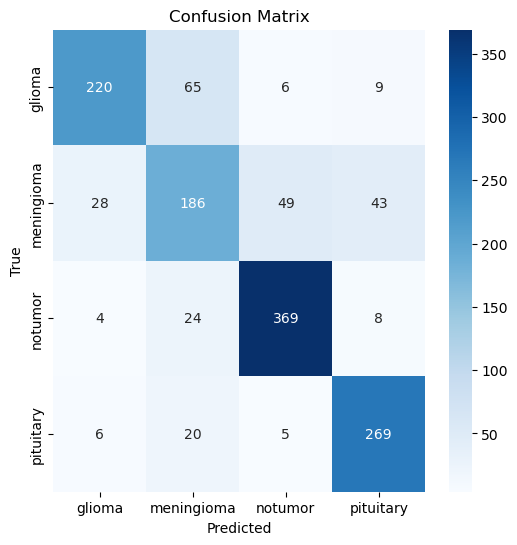

In [15]:
conf_matrix = confusion_matrix(test_labels_encoded, pred_labels)
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt="d",
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

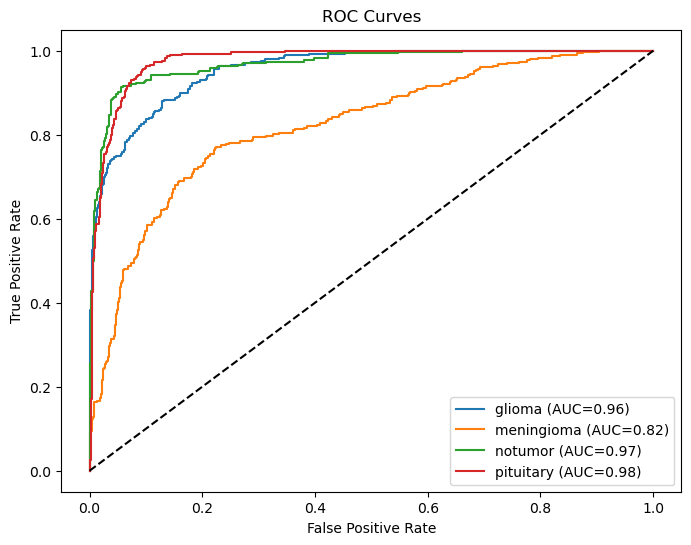

In [16]:
y_true_bin = label_binarize(test_labels_encoded, classes=list(range(len(CLASS_NAMES))))
fpr, tpr, roc_auc = {}, {}, {}

plt.figure(figsize=(8,6))
for i in range(len(CLASS_NAMES)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i],
             label=f"{CLASS_NAMES[i]} (AUC={roc_auc[i]:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

In [17]:
def detect_and_display(img_path, model, image_size=IMAGE_SIZE):
    try:
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        preds = model.predict(img_array)
        idx = int(np.argmax(preds, axis=1)[0])
        conf = float(np.max(preds, axis=1)[0])

        label = INDEX_TO_CLASS[idx]
        result = "No Tumor" if label.lower() == "notumor" else f"Tumor: {label}"

        plt.imshow(load_img(img_path))
        plt.axis("off")
        plt.title(f"{result} (Confidence: {conf*100:.2f}%)")
        plt.show()
    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


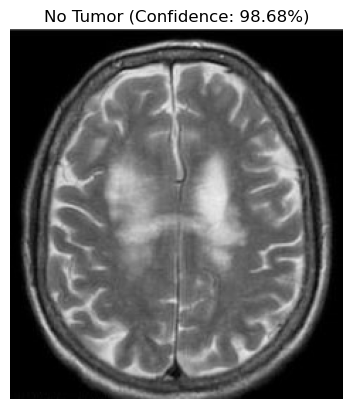

In [19]:
# Example usage:
detect_and_display("C:/M.Tech CSE/CV Project/Brain Tumor Detection and Classification/archive/Testing/notumor/Te-no_0014.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


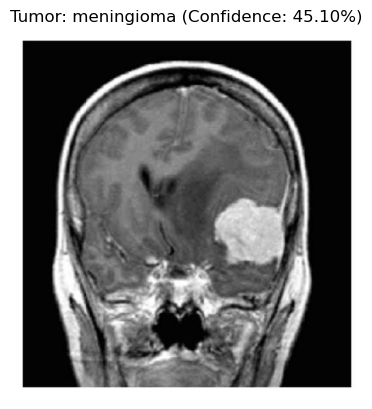

In [21]:
# Example usage:
detect_and_display("C:/M.Tech CSE/CV Project/Brain Tumor Detection and Classification/archive/Testing/meningioma/Te-me_0014.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


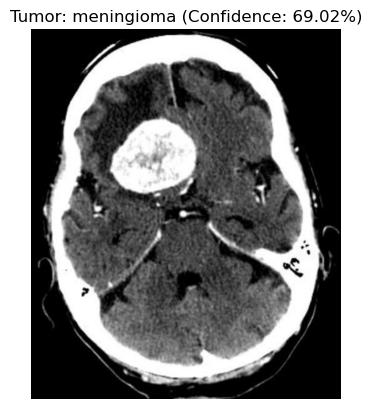

In [22]:
# Example usage:
detect_and_display("C:/M.Tech CSE/CV Project/Brain Tumor Detection and Classification/archive/Testing/meningioma/Te-me_0015.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


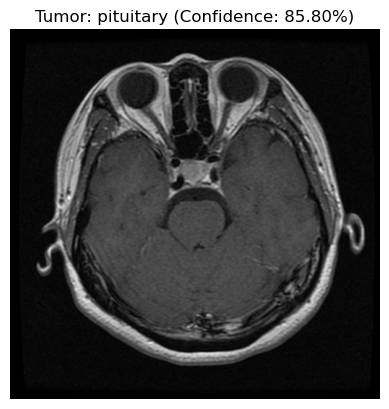

In [23]:
# Example usage:
detect_and_display("C:/M.Tech CSE/CV Project/Brain Tumor Detection and Classification/archive/Testing/pituitary/Te-pi_0011.jpg", model)